In [1]:
!pip install cvxpy

In [2]:
# !pip install pypose

In [3]:
import cvxpy as cp
import torch
#import pypose as nn
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import grad, Function
from scipy.linalg import solve_continuous_are

class doubleint(nn.Module):
    def __init__(self):
        super(doubleint, self).__init__()
        self.state_dim = 2
        self.control_dim = 1

    def f(self, x):
        return torch.tensor([x[1], -x[1]*0.1], dtype=torch.float32)

    def g(self, x):
        return torch.tensor([[0.0], [1.0]], dtype=torch.float32)  # Control effect

    def F(self, x, u):
        return torch.stack([x[1], -x[1]*0.1+u[0]])

class BicycleModel(nn.Module):
    def __init__(self):
        super(BicycleModel, self).__init__()
        self.state_dim = 3
        self.control_dim = 2

    def f(self, x):
        return torch.zeros(3)  # Dynamics with no control

    def g(self, x):
        return torch.tensor([[torch.cos(x[2]), 0], [torch.sin(x[2]), 0], [0, 1]], dtype=torch.float32)  # Control effect

    def F(self, x, u):
        return torch.stack([u[0] * torch.cos(x[2]), u[0] * torch.sin(x[2]), u[1]])


class NonlinearQuadrotorModel(nn.Module):
    def __init__(self):
        super(NonlinearQuadrotorModel, self).__init__()
        self.state_dim = 12  # Position (3), Velocity (3), Orientation (Euler angles, 3), Angular velocity (3)
        self.control_dim = 4  # Thrusts produced by the four rotors

        # Quadrotor physical constants
        self.mass = 0.5  # Mass of the quadrotor
        self.gravity = torch.tensor([0, 0, -9.81*0], dtype=torch.float32)  # Gravitational acceleration
        self.I = torch.diag(torch.tensor([0.005, 0.005, 0.01], dtype=torch.float32))  # Moment of inertia matrix
        self.L = 0.25  # Arm length

    def rotation_matrix(self, euler_angles):
        phi, theta, psi = euler_angles
        # Rotation matrices for roll (phi), pitch (theta), and yaw (psi)
        R_x = torch.tensor([
            [1, 0, 0],
            [0, torch.cos(phi), -torch.sin(phi)],
            [0, torch.sin(phi), torch.cos(phi)]
        ], dtype=torch.float32)

        R_y = torch.tensor([
            [torch.cos(theta), 0, torch.sin(theta)],
            [0, 1, 0],
            [-torch.sin(theta), 0, torch.cos(theta)]
        ], dtype=torch.float32)

        R_z = torch.tensor([
            [torch.cos(psi), -torch.sin(psi), 0],
            [torch.sin(psi), torch.cos(psi), 0],
            [0, 0, 1]
        ], dtype=torch.float32)

        R = torch.mm(R_z, torch.mm(R_y, R_x))
        return R

    def f(self, x):
        # Natural dynamics of the system without considering control inputs
        g_inertial = self.gravity
        R = self.rotation_matrix(x[6:9])
        a_inertial = torch.matmul(R, torch.tensor([0, 0, 0], dtype=torch.float32)) + g_inertial
        # Assuming zero angular acceleration for the f function
        angular_acc = torch.zeros(3, dtype=torch.float32)
        return torch.cat([x[3:6], a_inertial, torch.zeros(3, dtype=torch.float32), angular_acc])

    def g(self, x):
        # How control inputs affect the system's state
        g_matrix = torch.zeros((12, 4), dtype=torch.float32)
        R = self.rotation_matrix(x[6:9])

        # Thrust affects z-axis acceleration in the body frame, transformed to inertial frame
        thrust_vector = torch.matmul(R, torch.tensor([0, 0, 1/self.mass], dtype=torch.float32))
        g_matrix[3:6, 0] = thrust_vector

        # Torques affect angular accelerations
        g_matrix[9, 1] = 1 / self.I[0, 0]  # Roll torque effect
        g_matrix[10, 2] = 1 / self.I[1, 1]  # Pitch torque effect
        g_matrix[11, 3] = 1 / self.I[2, 2]  # Yaw torque effect

        return g_matrix

    def dynamics(self, x, u):
        # Combining natural dynamics (f) and control effects (g)
        dx = self.f(x) + torch.matmul(self.g(x), u)
        return dx

    def F(self, x, u):
        # Forward pass computes the state derivatives
        return self.dynamics(x, u)

class CartPoleModel(nn.Module):
    def __init__(self):
        super(CartPoleModel, self).__init__()
        self.state_dim = 4
        self.control_dim = 1

        self.mp = 0.1  # Mass of the pole
        self.M = 1.0    # Mass of the cart
        self.L = 1.0    # Length of the pole
        self.gravity = 9.81    # Acceleration due to gravity

    def f(self, x):
        # Dynamics of the system without control input (Fx=0)
        theta, theta_dot, x, x_dot = x
        Fx = torch.tensor(0.0, dtype=torch.float32)  # No external force

        # Common terms
        sin_theta = torch.sin(theta)
        cos_theta = torch.cos(theta)
        denominator = self.M + self.mp * (1 - cos_theta**2)

        # Equations for theta_double_dot and x_double_dot with Fx=0
        theta_double_dot = (-self.mp * self.L * sin_theta * cos_theta * theta_dot**2 + (self.M + self.mp) * self.gravity * sin_theta) / (self.L * denominator)
        x_double_dot = (-self.mp * self.L * sin_theta * theta_dot**2 + self.mp * self.gravity * sin_theta * cos_theta) / denominator

        return torch.tensor([theta_dot, theta_double_dot, x_dot, x_double_dot], dtype=torch.float32)

    def g(self, x):
        theta, theta_dot, x, x_dot = x
        sin_theta = torch.sin(theta)
        cos_theta = torch.cos(theta)
        denominator = 1.0 + 0.5 * (1 - cos_theta**2)

        # Partial derivatives of theta_double_dot and x_double_dot with respect to Fx
        theta_double_dot_Fx = cos_theta / (self.L * denominator)
        x_double_dot_Fx = 1 / denominator
        return torch.tensor([[0.0], [theta_double_dot_Fx], [0.0], [x_double_dot_Fx]], dtype=torch.float32)

    def F(self, x, u):
        theta, theta_dot, x_dot, _ = x
        Fx = u[0]

        sin_theta = torch.sin(theta)
        cos_theta = torch.cos(theta)
        denominator1 = self.M + self.mp * (1 - cos_theta**2)

        theta_double_dot = (-self.mp * self.L * sin_theta * cos_theta * theta_dot**2 + (self.M + self.mp) * 9.81 * sin_theta + cos_theta * Fx) / (self.L * denominator1)
        x_double_dot = (-self.mp * self.L * sin_theta * theta_dot**2 + self.mp * 9.81 * sin_theta * cos_theta + Fx) / denominator1

        return torch.stack([theta_dot, theta_double_dot, x_dot, x_double_dot])


In [4]:
class CBF(nn.Module):
    """
    The CBF is designed to compute safe control inputs for dynamic systems,
    ensuring collision avoidance through the application of high-order Control Barrier Functions (CBFs)
    and optimization of control inputs using an iterative Linear Quadratic Regulator (iLQR) approach.

    Attributes:
        f: A function representing the system dynamics without control inputs.
        g: A function representing the control effect on the system dynamics.
        F: A function representing the overall nonlinear dynamics of the system as a function of state and control.
        gamma_coeffs: A tensor of coefficients for the high-order CBFs, controlling the convergence rate towards safety.
        state_dim: The dimension of the state space.
        control_dim: The dimension of the control input space.
        horizon_length: The horizon length used in the iLQR algorithm for trajectory optimization.
        Q, R, Q_f: Cost matrices for the state, control input, and final state in the iLQR algorithm, respectively.

    Methods:
        h_base: Computes the base CBF for circular obstacles, used to ensure safety.
        lie_derivative: Calculates the Lie derivative of the CBF, essential for formulating the high-order CBF condition.
        high_order_cbf: Computes the high-order CBF condition for a specified order, ensuring safety over multiple time steps.
        linearize_dynamics: Linearizes the system dynamics around the current state and control, a key step in the iLQR algorithm.
        backward_pass: Performs the backward pass of the iLQR, computing control gains and feedforward terms for trajectory optimization.
        forward_pass: Executes the forward pass of the iLQR, applying computed control gains to generate a safe and optimized trajectory.
        nominal_controller: Implements the iLQR algorithm to compute the control input that minimizes the cost function while ensuring the system progresses towards the target state.
        safe_control_input: Computes a safe control input that respects CBF conditions, using convex optimization to adjust the nominal control input for safety.

    The controller integrates nonlinear dynamics, safety constraints through CBFs, and trajectory optimization via iLQR,
    making it suitable for tasks requiring safe navigation around obstacles in dynamic environments.
    """

    def __init__(self, model, gamma_coeffs, horizon_length=10, Q=None, R=None, Q_f=None):
        super(CBF, self).__init__()
        self.f = model.f  # Dynamics function
        self.g = model.g  # Control effect function
        self.F_continous = model.F #Continous dynamics
        self.F=lambda x, u: x + time_step * self.F_continous(x, u) #Discrete-time dynamics
        self.gamma_coeffs = torch.tensor(gamma_coeffs, dtype=torch.float32)  # Coefficients for high-order CBFs
        self.state_dim = model.state_dim  # Dimension of state
        self.control_dim = model.control_dim  # Dimension of the control input
        self.horizon_length = horizon_length  # Horizon length for iLQR

        # Initialize PID controller matrices
        self.Kp = torch.eye(model.control_dim, model.state_dim)*3  # Proportional gain matrix
        self.Ki = torch.eye(model.control_dim, model.state_dim) * 0.1  # Integral gain matrix
        self.Kd = torch.eye(model.control_dim, model.state_dim) * 0.5  # Derivative gain matrix

        # Cost matrices
        self.Q = torch.eye(self.state_dim) * 50 if Q is None else Q
        self.R = torch.eye(self.control_dim) * 1 if R is None else R
        self.Q_f = torch.eye(self.state_dim) * 1 if Q_f is None else Q_f

        # Input matrices
        self.K = torch.rand((self.horizon_length, self.control_dim, self.state_dim))
        self.k = torch.rand((self.horizon_length, self.control_dim))
        self.ku = torch.rand((self.horizon_length, self.control_dim, self.control_dim))

    def h_base(self, x, center, radius, type):
        """Base CBF for a circular obstacle."""
        if type=="circular":
          return (x[0] - center[0])**2 + (x[1] - center[1])**2 - radius**2
        elif type=="spherical":
          return (x[0] - center[0])**2 + (x[1] - center[1])**2 + (x[2] - center[2])**2 - radius**2

    def lie_derivative(self, h, x):
        x.requires_grad_(True)
        h_val = h(x)
        grad_h = grad(h_val, x, create_graph=True)[0]
        Lfh = torch.dot(grad_h, self.f(x))
        Lgh = grad_h @ self.g(x)
        return Lfh, Lgh

    def high_order_cbf(self, x, center, radius, order):
        """Compute high-order CBF condition for the given order. Please note that you must know the order for the CBF a-priori"""
        h_func = lambda x: self.h_base(x, center, radius, "circular")
        h = h_func(x)
        for i in range(1, order + 1):
            Lfh, Lgh = self.lie_derivative(lambda x: h_func(x), x)
            gamma_i = self.gamma_coeffs[i-1] if i-1 < len(self.gamma_coeffs) else self.gamma_coeffs[-1]
            h = Lfh + gamma_i * h
        return h

    def linearize_dynamics(self, x, u):
        """Linearize the dynamics around the current state and control input"""
        x = x.clone().detach().requires_grad_(True)
        u = u.clone().detach().requires_grad_(True)
        F_val = self.F(x, u)

        # Compute gradients for each component of F_val with respect to x and u
        A = torch.stack([grad(F_val[i], x, create_graph=True, retain_graph=True)[0] for i in range(len(F_val))])
        B = torch.stack([grad(F_val[i], u, create_graph=True, retain_graph=True)[0] for i in range(len(F_val))])
        return A, B

    def solve_riccati_equation(self, A, B):
        """Solve the algebraic Riccati equation using scipy's solver."""
        A_np = A.detach().numpy()
        B_np = B.detach().numpy()
        Q_np = self.Q.detach().numpy()
        R_np = self.R.detach().numpy()

        P_np = solve_continuous_are(A_np, B_np, Q_np, R_np)

        P = torch.from_numpy(P_np).float()
        return P

    def compute_lqr_gain(self, A, B, P):
        """Compute the LQR gain matrix K using the solution P to the Riccati equation"""
        K = torch.inverse(self.R + B.T @ P @ B) @ (B.T @ P @ A)
        return K

    def nominal_controller_lqr(self, x, target):
        """Compute the control input using the LQR gain."""
        # For demonstration, assume we have linearized dynamics at some nominal point
        A, B = self.linearize_dynamics(x, torch.zeros(self.control_dim))
        P = self.solve_riccati_equation(A, B)
        K = self.compute_lqr_gain(A, B, P)
        u = -K @ (x - target)
        return u

    def pid_controller(self, x, target, dt, error_sum, prev_error):
            """
            PID controller for adjusting the control input based on the error between the current state and the target state,
            using matrix gains for a multivariable control system. This version is adjusted to maintain gradient information.

            :param x: Current state.
            :param target: Target state.
            :param dt: Time step between control updates.
            :param error_sum: Cumulative sum of errors for the integral term.
            :param prev_error: Previous error for the derivative term.
            :return: Control input `u` shaped correctly and potentially retaining gradient information, updated error_sum, and prev_error.
            """
            # Ensure x and target have gradients for backward pass, if needed elsewhere
            x = x.requires_grad_(True) if not x.requires_grad else x
            target = target.requires_grad_(True) if not target.requires_grad else target

            # Calculate the current error and ensure it's a column vector for matrix multiplication
            error = (target - x).reshape((self.state_dim, 1))

            # Proportional term
            P = self.Kp @ error

            # Integral term
            error_sum += error.detach() * dt  # Detach to prevent gradients from flowing into error_sum
            I = self.Ki @ error_sum

            # Derivative term
            derivative = (error - prev_error) / dt
            D = self.Kd @ derivative

            # Control input
            u = P + I + D

            # Reshape u to ensure it's a flat tensor matching the control dimensions
            u = u.reshape(self.control_dim)

            # Update previous error for the next cycle, detaching to prevent unwanted gradient flow
            prev_error = error.detach()

            return u, error_sum, prev_error


    def safe_control_input(self, x0, x, target, centers, radii, order, time, error_sum, prev_error):
        """Compute a safe control input that respects CBF conditions using cvxpy."""
        dt = 0.01
        u = cp.Variable(self.control_dim)
        u0, error_sum, prev_error = self.pid_controller(x, target, dt, error_sum, prev_error)
        u0 = u0.detach().numpy()
        constraints = []
        for center, radius in zip(centers, radii):
            center = torch.tensor(center, dtype=torch.float32)
            h = lambda x: self.high_order_cbf(x, center, radius, order)
            Lfh, Lgh = self.lie_derivative(h, x)
            gamma = self.gamma_coeffs[0]  # Simplification for demonstration
            Lfh_numpy = Lfh.detach().numpy() if Lfh.requires_grad else Lfh.numpy()
            gamma_numpy = gamma.item()  # Assuming gamma is a scalar tensor
            h_x_numpy = h(x).detach().numpy() if h(x).requires_grad else h(x).numpy()
            Lgh_numpy = Lgh.detach().numpy() if Lgh.requires_grad else Lgh.numpy()

            # Then, use these numpy versions in the cvxpy constraint expression
            constraint_expr = Lfh_numpy + gamma_numpy * h_x_numpy + Lgh_numpy @ u >= 0

            #constraints.append(constraint_expr). #Adding safety constraint based on High order CBFs

        #print(u0)
        objective = cp.Minimize(cp.norm(u - u0, 2))
        prob = cp.Problem(objective, constraints)
        prob.solve()
        return torch.tensor(u0, dtype=torch.float32), error_sum, prev_error
        # return torch.tensor(u.value if u.value is not None else u0, dtype=torch.float32)


<ipython-input-5-756b70b9b791>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_safe =torch.tensor(u_safe, dtype=torch.float32)


tensor([-0.0472,  0.0023], grad_fn=<AddBackward0>)


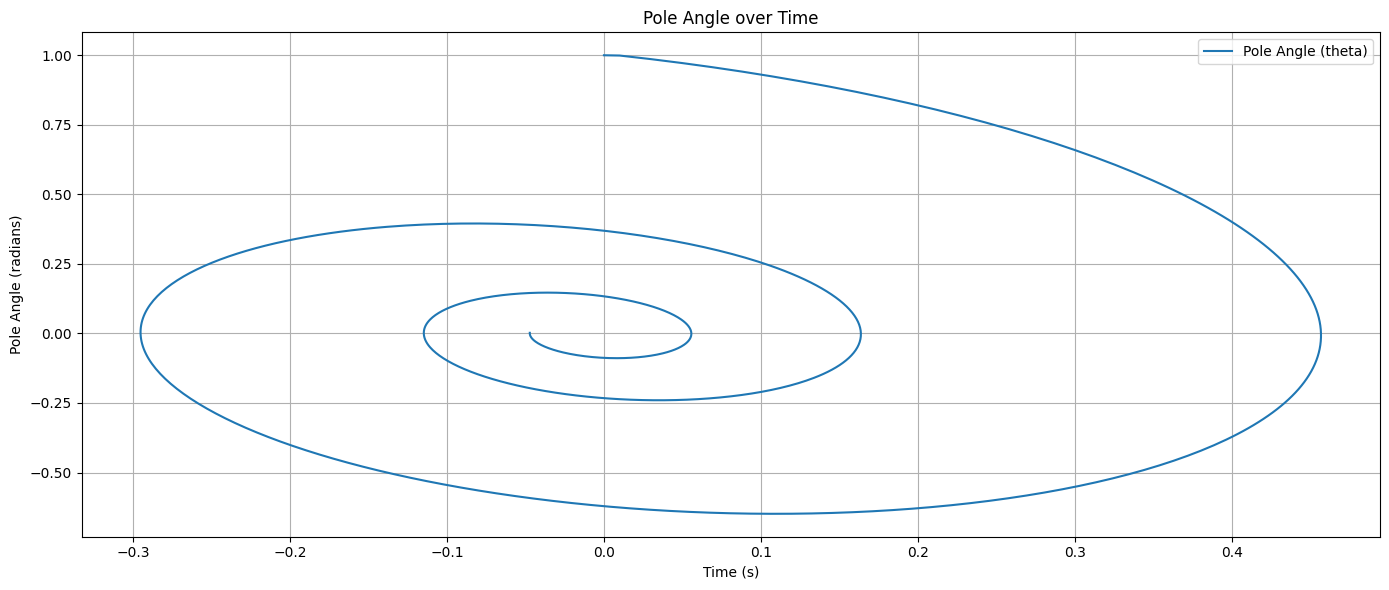

In [5]:
# Obstacle informations
centers = [[0.0, -0.5], [-1.7, -0.4] ]  # Centers of obstacles
radii = [0.3, 0.15]  # Radii of obstacles
x0s=[torch.tensor([0.0, 1.0], dtype=torch.float32) ,torch.tensor([0.14, 0.0, 0.0, 0.0], dtype=torch.float32), torch.tensor([0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0, 0], dtype=torch.float32) ]
targets=[torch.tensor([0.0, 0.0], dtype=torch.float32) , torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float32), torch.tensor([0.0, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.float32)]
time_step = 0.01  # Time step for simulation
simulation_time = 10.0  # Total simulation time
steps = int(simulation_time / time_step)

models = [doubleint(), CartPoleModel(), NonlinearQuadrotorModel()]
i=0
x0=x0s[i]
target=x0s[i]
model= models[i]
controller = CBF(model, [0.1], horizon_length=steps)

# Simulation loop
x = x0
trajectory = [x0]
error_sum = torch.zeros(model.state_dim, 1)
prev_error = torch.zeros(model.state_dim, 1)
for step in range(steps):
    u_safe, error_sum, prev_error = controller.safe_control_input(x0, x, target, centers, radii, 0, step, error_sum, prev_error)
    u_safe =torch.tensor(u_safe, dtype=torch.float32)
    # u_safe= torch.tensor(controller.safe_control_input(x0, x, target, centers, radii, 0, step, error_sum, prev_error), dtype=torch.float32)

    # print("yes")
    # Forward propagate dynamics
    x_dot = model.F(x, u_safe)
    x = x + x_dot * time_step
    trajectory.append(x.detach())
print(x)
trajectory_tensor = torch.stack(trajectory).detach()
plt.figure(figsize=(14, 6))

plt.plot(trajectory_tensor[:, 0], trajectory_tensor[:, 1], label='Pole Angle (theta)')
plt.xlabel('Time (s)')
plt.ylabel('Pole Angle (radians)')
plt.title('Pole Angle over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


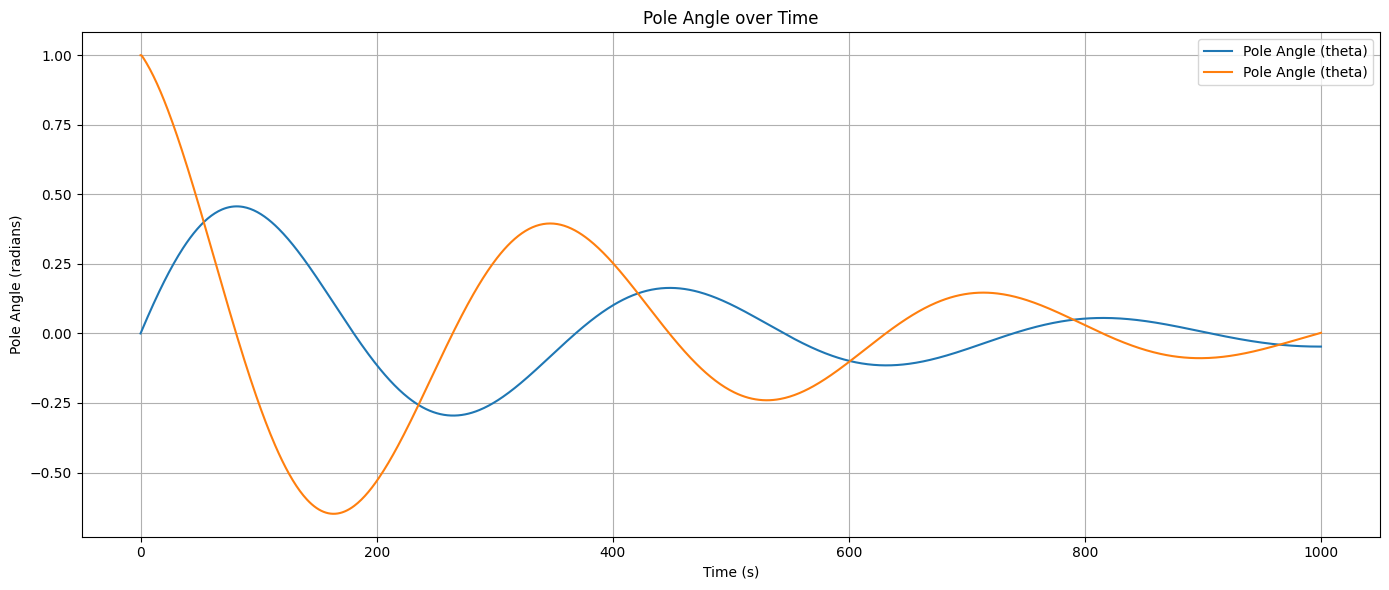

In [6]:
plt.figure(figsize=(14, 6))

plt.plot(trajectory_tensor[:, 0], label='Pole Angle (theta)')
plt.plot(trajectory_tensor[:, 1], label='Pole Angle (theta)')

plt.xlabel('Time (s)')
plt.ylabel('Pole Angle (radians)')
plt.title('Pole Angle over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [7]:
print(trajectory_tensor)

tensor([[ 0.0000e+00,  1.0000e+00],
        [ 1.0000e-02,  9.9900e-01],
        [ 1.9990e-02,  9.9270e-01],
        ...,
        [-4.7243e-02, -9.1228e-05],
        [-4.7244e-02,  1.0840e-03],
        [-4.7233e-02,  2.2527e-03]])
